<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/RSNA_ATD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
from torch import nn
from IPython.display import clear_output

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d awsaf49/rsna-atd-512x512-png-v2-dataset
!unzip \*.zip && rm *.zip
clear_output()

In [3]:
# train
BASE_PATH = '.'
dataframe = pd.read_csv(f"{BASE_PATH}/train.csv")
dataframe["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"
dataframe = dataframe.drop_duplicates()

dataframe.head(10)

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,./train_images/10004/21057/362.png,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,./train_images/10004/21057/363.png,512,512
2,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,364,Active_Extravasation,./train_images/10004/21057/364.png,512,512
3,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,365,Active_Extravasation,./train_images/10004/21057/365.png,512,512
4,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,366,Active_Extravasation,./train_images/10004/21057/366.png,512,512
5,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,367,Active_Extravasation,./train_images/10004/21057/367.png,512,512
6,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,368,Active_Extravasation,./train_images/10004/21057/368.png,512,512
7,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,369,Active_Extravasation,./train_images/10004/21057/369.png,512,512
8,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,370,Active_Extravasation,./train_images/10004/21057/370.png,512,512
9,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,371,Active_Extravasation,./train_images/10004/21057/371.png,512,512


#Torch

In [ ]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 16
    EPOCHS = 10
    TARGET_COLS  = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]

config = Config()
len(Config.TARGET_COLS)
torch.manual_seed(Config.SEED)


11

In [ ]:
# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

In [ ]:
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

class CustomDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]).convert('RGB')
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define any image transformations you want to apply, here we also add augmentation.
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(256),   # Random crop and resize
    transforms.RandomHorizontalFlip(),    # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# get image_paths and labels
print("[INFO] Building the dataset...")

train_paths  = train_data.image_path.tolist()
train_labels = train_data[config.TARGET_COLS].values

val_paths  = val_data.image_path.tolist()
val_labels = val_data[config.TARGET_COLS].values


#torch dataset
batch_size = 32

# Create the datasets

dataset_train = CustomDataset(train_paths, train_labels, transform=transform)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)


dataset_val = CustomDataset(val_paths, val_labels, transform=transform)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)


# Define your dataset size and other configuration parameters
dataset_size = len(dataset_train)  # Assuming you have defined 'dataset' earlier
batch_size = 32  # Your batch size
total_epochs = 50  # Total number of epochs

# Calculate total train steps
total_train_steps = dataset_size * batch_size * total_epochs

# Define warmup steps as 10% of total train steps
warmup_steps = int(total_train_steps * 0.10)

# Define decay steps as the remaining steps after warmup
decay_steps = total_train_steps - warmup_steps

print(f"Total Train Steps: {total_train_steps}")
print(f"Warmup Steps: {warmup_steps}")
print(f"Decay Steps: {decay_steps}")

[INFO] Building the dataset...
Total Train Steps: 15379200
Warmup Steps: 1537920
Decay Steps: 13841280


In [ ]:
for img, label in train_dataloader:
  print(img.shape)
  break

torch.Size([32, 3, 256, 256])


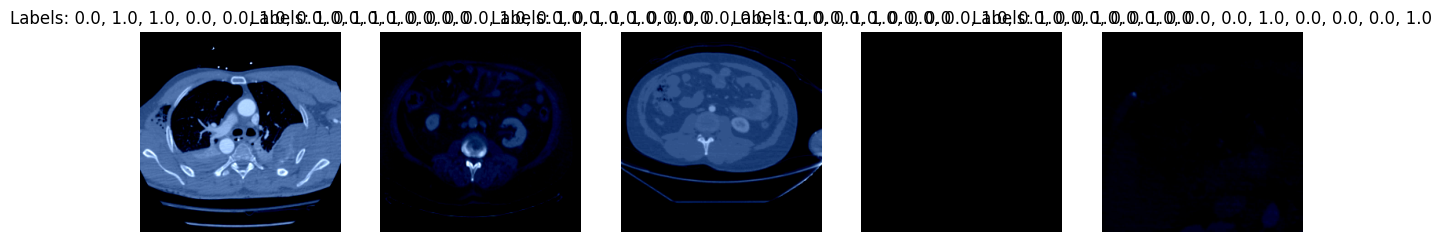

In [ ]:
#a function to display images
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for idx, (image, label) in enumerate(zip(images, labels)):
        image = image.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C) for displaying
        axes[idx].imshow(image)
        label_str = ", ".join([str(val) for val in label])  # Convert label tensor to string
        axes[idx].set_title(f"Labels: {label_str}")
        axes[idx].axis("off")
    plt.show()

# Load a few images for visualization
num_images_to_display = 5
sample_indices = torch.randint(len(dataset_train), size=(num_images_to_display,))
sample_images = [dataset_train[i][0] for i in sample_indices]
sample_labels = [dataset_train[i][1] for i in sample_indices]

# Convert label tensors to numpy arrays for display
sample_labels_np = [label.numpy() for label in sample_labels]

# Display the sample images
show_images(sample_images, sample_labels_np)

In [ ]:
device = torch.device('cude' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(SimpleCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 64 * 64, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Instantiate the model
model = SimpleCNN(num_classes=11).to(device)

In [ ]:
import torch
import torch.nn as nn


# Instantiate the model
model = SimpleCNN(num_classes=11).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

total_epochs = 25  # Replace with the total number of epochs


train_losses = []  # To store training losses
val_losses = []    # To store validation losses
val_accuracies = []  # To store validation accuracies

for epoch in range(total_epochs):
    model.train()  # Set the model to training mode
    for images, labels in train_dataloader:
        optimizer.zero_grad()

        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

    # Update learning rate using the scheduler
    scheduler.step()

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

            predicted = (outputs > 0.5).int()  # Convert logits to binary predictions
            total += labels.size(0) * labels.size(1)  # Total number of predictions
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_dataloader)
    val_accuracy = 100.0 * correct / total

     # Append loss and accuracy values to lists
    train_losses.append(loss.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{total_epochs}] - Loss: {loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.2f}%")

KeyboardInterrupt: ignored

In [ ]:
# Plot training and validation progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Select a random image from the validation dataset
random_index = np.random.randint(len(dataset_val))
image, label = dataset_val[random_index]

# Move the image to the GPU if available
image = image.to(device)

# Pass the image through the model
with torch.no_grad():
    output = model(image.unsqueeze(0))  # Unsqueeze to add batch dimension

# Convert the output logits to probabilities using sigmoid function
predicted_probs = torch.sigmoid(output)[0]

# Convert predicted probabilities to binary predictions
predicted_labels = (predicted_probs > 0.5).int()


# Display the image, actual labels, and predicted labels
plt.imshow(image.permute(1, 2, 0).cpu())  # Move image to CPU and change channel order
#plt.title(f"Actual Labels: {label}\nPredicted Labels: {predicted_labels}")
plt.title(f"Actual Labels: {label}\nPredicted Labels: {predicted_labels}")
plt.show()

#TF Dataset

In [4]:
!pip install -q git+https://github.com/keras-team/keras-cv

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 7.8 MB/s eta 0:00:00


In [5]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras_cv
import keras_core as keras
from keras_core import layers
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from keras_cv import layers

Using TensorFlow backend


In [6]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 64
    EPOCHS = 20
    TARGET_COLS  = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]
    AUTOTUNE = tf.data.AUTOTUNE

config = Config()

In [7]:
# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

In [8]:
def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0

    label = tf.cast(label, tf.float32)
    #         bowel       fluid       kidney      liver       spleen
    labels = (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])

    return (image, labels)


def apply_augmentation(images, labels):
    augmenter = keras_cv.layers.Augmenter(
        [
            keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
            keras_cv.layers.RandomCutout(height_factor=0.2, width_factor=0.2),

        ]
    )
    return (augmenter(images), labels)


def build_dataset(image_paths, labels):
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .map(apply_augmentation, num_parallel_calls=config.AUTOTUNE)
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [9]:
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

ds = build_dataset(image_paths=paths, labels=labels)
images, labels = next(iter(ds))
images.shape, [label.shape for label in labels]

(TensorShape([64, 256, 256, 3]),
 [TensorShape([64, 1]),
  TensorShape([64, 1]),
  TensorShape([64, 3]),
  TensorShape([64, 3]),
  TensorShape([64, 3])])

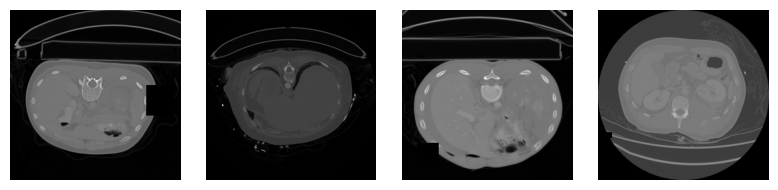

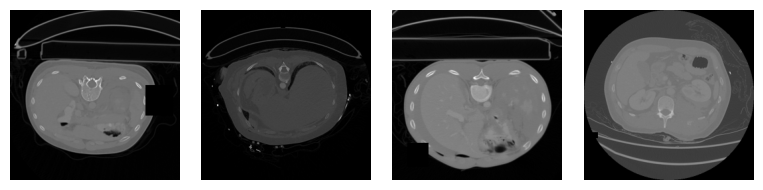

In [10]:
# No more customizing your plots by hand, KerasCV has your back ;)
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=1,
    cols=4,
)

In [11]:
def build_model(warmup_steps, decay_steps):
    # Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)

    # Define Backbone
    backbone = keras_cv.models.ResNetBackbone.from_preset("resnet50_imagenet")
    include_rescaling = False
    x = inputs

    # GAP to get the activation maps
    gap = keras.layers.GlobalAveragePooling2D()
    x = gap(x)

    # Define 'necks' for each head
    x_bowel = keras.layers.Dense(32, activation='silu')(x)
    x_extra = keras.layers.Dense(32, activation='silu')(x)
    x_liver = keras.layers.Dense(32, activation='silu')(x)
    x_kidney = keras.layers.Dense(32, activation='silu')(x)
    x_spleen = keras.layers.Dense(32, activation='silu')(x)

    # Define heads
    out_bowel = keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel) # use sigmoid to convert predictions to [0-1]
    out_extra = keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra) # use sigmoid to convert predictions to [0-1]
    out_liver = keras.layers.Dense(3, name='liver', activation='softmax')(x_liver) # use softmax for the liver head
    out_kidney = keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney) # use softmax for the kidney head
    out_spleen = keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen) # use softmax for the spleen head

    # Concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    print("[INFO] Building the model...")
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Cosine Decay
    cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.0,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)
    loss = {
        "bowel":keras.losses.BinaryCrossentropy(),
        "extra":keras.losses.BinaryCrossentropy(),
        "liver":keras.losses.CategoricalCrossentropy(),
        "kidney":keras.losses.CategoricalCrossentropy(),
        "spleen":keras.losses.CategoricalCrossentropy(),
    }
    metrics = {
        "bowel":["accuracy"],
        "extra":["accuracy"],
        "liver":["accuracy"],
        "kidney":["accuracy"],
        "spleen":["accuracy"],
    }
    print("[INFO] Compiling the model...")
    model.compile(
        optimizer=optimizer,
      loss=loss,
      metrics=metrics
    )

    return model

In [12]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values; train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data.image_path.values; valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...
total_train_steps=193280
warmup_steps=19328
decay_steps=173952


In [ ]:
# build the model
print("[INFO] Building the model...")
model = build_model(warmup_steps, decay_steps)

# train
print("[INFO] Training...")
history = model.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds,
)

[INFO] Building the model...
94657128/94657128 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[INFO] Building the model...
[INFO] Compiling the model...
[INFO] Training...
Epoch 1/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 155s 918ms/step - bowel_accuracy: 0.1714 - extra_accuracy: 0.8524 - kidney_accuracy: 0.7899 - liver_accuracy: 0.7089 - loss: 4.5646 - spleen_accuracy: 0.1484 - val_bowel_accuracy: 0.5205 - val_extra_accuracy: 0.6967 - val_kidney_accuracy: 0.8113 - val_liver_accuracy: 0.8697 - val_loss: 4.3264 - val_spleen_accuracy: 0.6711
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 135s 880ms/step - bowel_accuracy: 0.1697 - extra_accuracy: 0.8526 - kidney_accuracy: 0.7931 - liver_accuracy: 0.7066 - loss: 4.3679 - spleen_accuracy: 0.6160 - val_bowel_accuracy: 0.5205 - val_extra_accuracy: 0.6967 - val_kidney_accuracy: 0.8113 - val_liver_accuracy: 0.8697 - val_loss: 4.1006 - val_spleen_accuracy: 0.6773
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 137s 892ms/step - bowel_accuracy: 0.1673 - extra_accuracy: 0.8524 - kidney

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a 3x2 grid for the subplots
fig = plt.figure(figsize=(5, 15))
gs = gridspec.GridSpec(3, 2)

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Get the current subplot
    ax = fig.add_subplot(gs[i])

    # Plot training accuracy
    ax.plot(history.history[name + '_accuracy'], label='Training ' + name)

    # Plot validation accuracy
    ax.plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)

    # Set the title, xlabel, and ylabel
    ax.set_title(name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [ ]:
# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# Find mean accuracy
best_acc = np.mean(
    [best_acc_bowel,
     best_acc_extra,
     best_acc_liver,
     best_acc_kidney,
     best_acc_spleen
])


print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

In [ ]:
model.save("rsna-v1.keras")